# Project 1: Real / Fake image detection

Students: Shalini Priya, Tom Wysocki, Stéphanie Monteiro <br/>
Task: Image classifcation <br/>
Model: Feedforward neural network applied to the (vectorized) images <br/>
Dataset: https://www.kaggle.com/ciplab/real-and-fake-face-detection <br/>

We have implemented two methods , one using Pytorch library and the other one using Tensor flow

# Pytorch Version

## Libraries

In [21]:
import os
import random
import shutil
import fnmatch
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import string

## 1. Check and preprocess data

In [22]:
fake_files = os.listdir('real_and_fake_face_detection/real_and_fake_face/training_fake/')
real_files = os.listdir('real_and_fake_face_detection/real_and_fake_face/training_real/')
print(len(fake_files))
print(len(real_files))

960
1081


In [24]:
root_dir = 'real_and_fake_face_detection/real_and_fake_face/'
new_root = 'all/'
classes = ['training_fake', 'training_real']

# Create train / test / val folders
for cls in classes:
    if os.path.exists(root_dir + new_root+ 'train/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir + new_root+ 'train/' + cls.split("_")[1])
    if os.path.exists(root_dir +new_root + 'test/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir +new_root + 'test/' + cls.split("_")[1])
    if os.path.exists(root_dir +new_root +'val/' + cls.split("_")[1]) == False:
        os.makedirs(root_dir +new_root +'val/' + cls.split("_")[1])
    
# Create partition of the data after shuffling
for cls in classes:
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)

    # 0.70 = training ratio , 0.20 = test ratio, 0.10 = validation ratio
    train_FileNames, test_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)*0.70),int(len(allFileNames)*0.90)])

    # Convert file names from array to list

    train_FileNames = [src+'/'+ name for name in train_FileNames]
    val_FileNames = [src+'/' + name for name in val_FileNames]
    test_FileNames = [src+'/' + name for name in test_FileNames]

    print("----------\n")
    print(cls.split("_")[1])
    print('Total images  : '+str(len(allFileNames)))
    print('Training : '+str(len(train_FileNames)))
    print('Testing : '+str(len(test_FileNames)))
    print('Validation : '+str(len(val_FileNames)))
    
    # Copy paste images to target directory

    for name in train_FileNames:
        shutil.copy(name, root_dir + new_root+'train/'+cls.split("_")[1])
    
    for name in test_FileNames:
        shutil.copy(name,root_dir + new_root+'test/'+cls.split("_")[1] )

    for name in val_FileNames:
        shutil.copy(name, root_dir +new_root+'val/'+cls.split("_")[1] )

print("----------\n")
print(new_root.split("/")[0])
print("Total images : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root) for f in files])))
print("Training : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'train/') for f in files])))
print("Testing : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'test/') for f in files])))
print("Validation : "+ str(len([f for path, subdirs, files in os.walk(root_dir + new_root+'val/') for f in files])))

----------

fake
Total images  : 960
Training : 672
Testing : 192
Validation : 96
----------

real
Total images  : 1081
Training : 756
Testing : 216
Validation : 109
----------

all
Total images : 2041
Training : 1428
Testing : 408
Validation : 205


## 2. Write a Dataset class for creating the train and test datasets (and corresponding dataloaders)

In [36]:
class ImageDataset(Dataset):

    def __init__(self, image_dir):
        """Here we initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        self.image_labels = sorted(self._find_labels(image_dir))

    def __len__(self):
        """Here we return the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample (image, label) for a given index."""
        # Take as input 'index' and returns the corresponding item as a pytorch tensor
        x = io.imread(self.image_files[index])
        x = transform.resize(x, (128,128))
        x = torch.tensor(x,dtype=float)
        y = self.image_labels[index]
        return x, y 

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files
    
    def _find_labels(self, directory, pattern='*.jpg'):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        labels = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                labels.append(os.path.split(root)[1])
        l = list(map(class_to_idx.get, labels))
        return l

In [37]:
# Initialize the train / test / val datasets by providing the directories to the image corpus data
train_dir = root_dir+'/all/train'
test_dir = root_dir+'/all/test'
val_dir = root_dir+'/all/val'

train_dataset = ImageDataset(image_dir=train_dir)
test_dataset = ImageDataset(image_dir=test_dir)
val_dataset = ImageDataset(image_dir=val_dir)

1428
0
torch.Size([128, 128, 3])


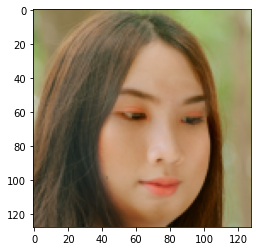

In [38]:
# Use the '_find_files' method to get the list of images paths in the train dataset
images_list = train_dataset._find_files(train_dir)
#for im in images_list:
    #print(im)
print(len(images_list))

# Load the image with index '0' from the train dataset, print its label, its shape and display it
image, label = train_dataset.__getitem__(0)
print(label)
print(image.shape)
plt.imshow(image)
plt.show()

In [39]:
# Create dataloaders, which sample over the train / test / val datasets with a batch size of 64
batch_size = 3
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

## 3. Define the neural network model

In [40]:
# Define an MLP classifier model with two layers and a non-linear activation function
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        # define the two linear layers and the activation function
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = act_fn
    
    def forward(self, x):
        
        # 'forward' method which computes the output y from the input x
        # apply: layer1, activation function, layer 2, and activation function again
        h = self.layer1(x)
        h = self.activation_fn(h)
        h = self.layer2(h)
        y = self.activation_fn(h)
        
        return y

## 4.1. Define the hyperparameters to create an instance of the model and the parameters required to train neural network (without validation)

In [47]:
# Hyperparameters to create an instance of the model
input_size = train_dataset[0][0].shape[0]*train_dataset[0][0].shape[1]*train_dataset[0][0].shape[2]
hidden_size = 100
act_fn = nn.Sigmoid()
output_size = len(classes)

# Parameters to train the mlp classifier
num_epochs = 10
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Instanciate the model
model = MLPClassif(input_size, hidden_size, output_size, act_fn)

# Display the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  4915502


## 5.1. Write the training loop for training the model (without validation)

In [44]:
# Training function: process batches of data at each epoch
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # Prepare the inputs (vectorize images) and labels 
            images = images.reshape(images.shape[0], -1)

            # Copy the data (images and labels) to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            labels_predicted = model(images.float())
            
            # Backpropagation: compute the gradients and apply the gradient descent algorithm
            loss = loss_fn(labels_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss to update the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_all_epochs

In [45]:
model, loss_all_epochs = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device)

Epoch [1/10], Loss: 330.4906
Epoch [2/10], Loss: 330.1123
Epoch [3/10], Loss: 329.2391
Epoch [4/10], Loss: 330.0054
Epoch [5/10], Loss: 329.8949
Epoch [6/10], Loss: 329.6443
Epoch [7/10], Loss: 329.5526
Epoch [8/10], Loss: 329.5684
Epoch [9/10], Loss: 329.5990
Epoch [10/10], Loss: 329.4819


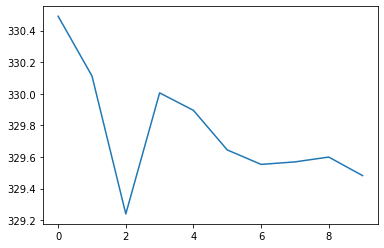

In [49]:
# Display the loss over epochs
plt.plot(loss_all_epochs)
plt.show()

## 6.1. Evaluate the model on the test data (without validation)

In [50]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.reshape(images.shape[0], -1).to(device)
            labels = labels.to(device)
            y_predicted = model(images.float())
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [51]:
# Evaluate the model on the test set and display the accuracy
accuracy = eval_mlp_classifier(model, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  47.05882352941177 %


## 4.2. Define the hyperparameters to create an instance of the model and the parameters required to train neural network (with validation)

In [60]:
# Hyperparameters to create an instance of the model
input_size = train_dataset[0][0].shape[0]*train_dataset[0][0].shape[1]*train_dataset[0][0].shape[2]
hidden_size = 100
act_fn = nn.Sigmoid()
output_size = len(classes)

# Parameters to train the mlp classifier
num_epochs = 10
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Instanciate the model
model_val = MLPClassif(input_size, hidden_size, output_size, act_fn)

# Display the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model_val.parameters()))

Total number of parameters:  4915502


## 5.2. Write the training loop for training the model (with validation)

In [61]:
# Training function with validation
def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device='cuda'):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss and validation accuracy over epochs
    loss_all_epochs = []
    accuracy_val_all_epochs = []
    
    # Initialize the "optimal" accuracy, which will be used for performing validation
    accuracy_opt = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches (using the dataloader)
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # Vectorize the images and copy the data to the device
            images = images.reshape(-1, input_size)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            labels_predicted = model(images.float())
            loss = loss_fn(labels_predicted, labels)
            
            # Gradient descent
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record the loss over all batches and the accuracy on the validation set
        loss_all_epochs.append(loss_current_epoch)
        accuracy_current_epoch = eval_mlp_classifier(model, valid_dataloader, device)
        accuracy_val_all_epochs.append(accuracy_current_epoch)
        
        # Display the training loss and validation accuracy
        print('Epoch [{}/{}], Training loss: {:.4f} ; Validation accuracy: {:.4f}'
               .format(epoch+1, num_epochs, loss_current_epoch, accuracy_current_epoch))
            
        # Now record the model if the accuracy is higher than the "optimal" value
        if accuracy_current_epoch > accuracy_opt:
            model_opt = model
            accuracy_opt = accuracy_current_epoch

    return model_opt, loss_all_epochs, accuracy_val_all_epochs

In [63]:
# Train the MLP classifier model with validation
model_val, loss_all_epochs, accuracy_validation = train_val_mlp_classifier(model_val, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device)

Epoch [1/10], Training loss: 329.3663 ; Validation accuracy: 53.1707
Epoch [2/10], Training loss: 328.5305 ; Validation accuracy: 53.1707
Epoch [3/10], Training loss: 327.7014 ; Validation accuracy: 55.1220
Epoch [4/10], Training loss: 326.9756 ; Validation accuracy: 60.0000
Epoch [5/10], Training loss: 326.3771 ; Validation accuracy: 55.1220
Epoch [6/10], Training loss: 325.6967 ; Validation accuracy: 59.5122
Epoch [7/10], Training loss: 325.0542 ; Validation accuracy: 56.5854
Epoch [8/10], Training loss: 324.3339 ; Validation accuracy: 60.4878
Epoch [9/10], Training loss: 323.6661 ; Validation accuracy: 56.5854
Epoch [10/10], Training loss: 323.3373 ; Validation accuracy: 57.0732


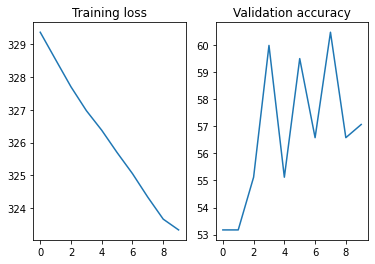

In [71]:
# Display the training loss and validation accuracy over epochs
fig = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_all_epochs)
plt.title('Training loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_validation)
plt.title('Validation accuracy')
plt.show()

## 6.1. Evaluate the model on the test data (with validation)

In [66]:
# Evaluate the model on the test set and display the accuracy
accuracy = eval_mlp_classifier(model_val, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  52.69607843137255 %


## 7.2. Save the trained model parameters, and the obtained results (with validation)

In [67]:
# Save the model parameters
torch.save(model.state_dict(), 'model_mlp_classif_val'+'b'+str(batch_size)+'h'+str(hidden_size)+'e'+str(num_epochs)+'.pt')

In [72]:
# Save the figure with the training loss and validation accuracy over epochs
fig.savefig('results'+'b'+str(batch_size)+'h'+str(hidden_size)+'e'+str(num_epochs)+'_val'+'.png')

# Tensorflow version

## Libraries

In [ ]:
import os
import numpy as np 
import pandas as pd 
import cv2
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
import random
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D,BatchNormalization
from sklearn.preprocessing import LabelBinarizer
from keras import regularizers

In [ ]:
real = "real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "real_and_fake_face_detection/real_and_fake_face/training_fake"
# create a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)
print(len(real_path))
print(len(fake_path))

1081
960


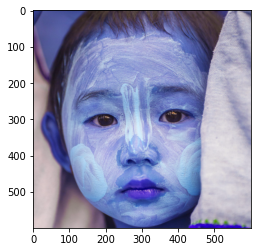

In [ ]:
plt.imshow(cv2.imread(os.path.join(real, real_path[0])))
plt.show()

## Write Dataset for Training and test

In [ ]:
img_size = int(128)

def create_training_data():
    training_data = []
    y = []
    for img in tqdm(real_path[:981]):
        path = os.path.join(real, img)
        #         label = [1]
        image = cv2.resize(cv2.imread(path), (img_size, img_size))
        training_data.append(np.array(image))
        y.append(1)

    for img in tqdm(fake_path[:860]):
        path = os.path.join(fake, img)
        #         label = [0]
        image = cv2.resize(cv2.imread(path), (img_size, img_size))
        training_data.append(np.array(image))
        y.append(0)

    return (training_data, y)

def create_test_data():
    test_data = []
    output_data = []
    for img in tqdm(real_path[981:]):
        path = os.path.join(real, img)
        image = cv2.resize(cv2.imread(path), (img_size, img_size))

        test_data.append(np.array(image))
        output_data.append(1)

    for img in tqdm(fake_path[860:]):
        path = os.path.join(fake, img)
        image = cv2.resize(cv2.imread(path), (img_size, img_size))

        test_data.append(np.array(image))
        output_data.append(0)

    return (test_data, output_data)

X_test, Y_test = create_test_data()

100%|██████████| 100/100 [00:01<00:00, 59.41it/s]


In [ ]:
X_train, Y_train = create_training_data()

100%|██████████| 860/860 [04:39<00:00,  3.08it/s]


In [ ]:
l=list(zip(X_train,Y_train))
shuffle(l)
X_train,Y_train=zip(*l)

In [ ]:
# print(X[0].reshape(-1, 50, 50, 1))
X_train = np.array(X_train)
print(X_train)

[[[[ 51  63  51]
   [ 54  65  54]
   [ 54  67  55]
   ...
   [102 119 135]
   [111 129 158]
   [115 133 165]]

  [[ 38  45  38]
   [ 36  43  36]
   [ 42  52  40]
   ...
   [107 118 130]
   [102 118 140]
   [110 126 134]]

  [[ 37  44  37]
   [ 38  43  34]
   [ 43  51  40]
   ...
   [109 119 127]
   [104 117 139]
   [ 97 112 118]]

  ...

  [[ 27  33  45]
   [ 17  20  23]
   [ 35  43  72]
   ...
   [ 37  44  71]
   [ 35  42  60]
   [ 32  42  72]]

  [[ 22  29  43]
   [ 23  31  46]
   [ 36  40  66]
   ...
   [ 30  37  64]
   [ 32  39  72]
   [ 31  39  69]]

  [[ 22  27  47]
   [ 22  31  40]
   [ 35  39  64]
   ...
   [ 22  29  49]
   [ 22  29  47]
   [ 22  29  47]]]


 [[[ 33  39  46]
   [ 34  40  47]
   [ 32  38  45]
   ...
   [ 37  43  50]
   [ 37  39  57]
   [ 37  40  55]]

  [[ 34  40  47]
   [ 35  41  48]
   [ 35  41  48]
   ...
   [ 39  45  52]
   [ 38  40  59]
   [ 36  42  50]]

  [[ 34  40  47]
   [ 35  41  48]
   [ 30  36  43]
   ...
   [ 31  37  44]
   [ 29  35  42]
   [ 27  33

## Normalize the Data

In [ ]:
#divide by 255 to squish values to 0 - 1 normalization
X_train = X_train/255.0
Y_train=np.array(Y_train)
print(X_train)
print(Y_train)

[[[[0.2        0.24705882 0.2       ]
   [0.21176471 0.25490196 0.21176471]
   [0.21176471 0.2627451  0.21568627]
   ...
   [0.4        0.46666667 0.52941176]
   [0.43529412 0.50588235 0.61960784]
   [0.45098039 0.52156863 0.64705882]]

  [[0.14901961 0.17647059 0.14901961]
   [0.14117647 0.16862745 0.14117647]
   [0.16470588 0.20392157 0.15686275]
   ...
   [0.41960784 0.4627451  0.50980392]
   [0.4        0.4627451  0.54901961]
   [0.43137255 0.49411765 0.5254902 ]]

  [[0.14509804 0.17254902 0.14509804]
   [0.14901961 0.16862745 0.13333333]
   [0.16862745 0.2        0.15686275]
   ...
   [0.42745098 0.46666667 0.49803922]
   [0.40784314 0.45882353 0.54509804]
   [0.38039216 0.43921569 0.4627451 ]]

  ...

  [[0.10588235 0.12941176 0.17647059]
   [0.06666667 0.07843137 0.09019608]
   [0.1372549  0.16862745 0.28235294]
   ...
   [0.14509804 0.17254902 0.27843137]
   [0.1372549  0.16470588 0.23529412]
   [0.1254902  0.16470588 0.28235294]]

  [[0.08627451 0.11372549 0.16862745]
   [0.0

In [ ]:
X_test = np.array(X_test)

In [ ]:
#divide by 255 to squish values to 0 - 1 normalization
X_test = X_test/255.0
Y_test=np.array(Y_test)
print(X_test)
print(Y_test)
print(X_test.shape)

[[[[0.92941176 0.90196078 0.89019608]
   [0.90980392 0.87843137 0.87843137]
   [0.95294118 0.9254902  0.91372549]
   ...
   [0.94117647 0.91372549 0.90196078]
   [0.96862745 0.94509804 0.9372549 ]
   [0.97647059 0.96078431 0.94901961]]

  [[0.90196078 0.87058824 0.85490196]
   [0.9254902  0.89803922 0.88235294]
   [0.93333333 0.91372549 0.90196078]
   ...
   [0.95294118 0.92156863 0.88627451]
   [0.95686275 0.93333333 0.90588235]
   [0.96862745 0.95294118 0.92156863]]

  [[0.91372549 0.87843137 0.8627451 ]
   [0.93333333 0.89803922 0.88235294]
   [0.89803922 0.8745098  0.8627451 ]
   ...
   [0.91764706 0.87843137 0.82745098]
   [0.90980392 0.88235294 0.84705882]
   [0.93333333 0.91372549 0.87843137]]

  ...

  [[0.23137255 0.4        0.54509804]
   [0.16862745 0.32156863 0.43529412]
   [0.19215686 0.30588235 0.40784314]
   ...
   [0.24313725 0.43529412 0.62352941]
   [0.34901961 0.54509804 0.7254902 ]
   [0.31764706 0.52156863 0.70196078]]

  [[0.1372549  0.35294118 0.44313725]
   [0.0

In [ ]:
print(X_train.shape[1:])
print(X_train.shape[:])

(128, 128, 3)
(1841, 128, 128, 3)


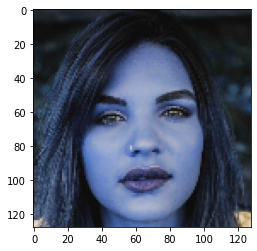

(128, 128, 3)


In [ ]:
df=pd.DataFrame(Y_train)
df[0].value_counts()
plt.imshow(X_train[1])
plt.show()
print(X_train[1].shape)

In [ ]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)
print(Y_test.shape)
print(Y_train.shape)

(200, 1)
(1841, 1)


## Define the model

In [ ]:
lsize = 128
model = Sequential()
model.add(Dense(lsize, input_shape=(128,128,3),activation='relu')) 
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(rate=0.05))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.05))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128, 128, 128)     512       
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 batch_normalization (BatchN  (None, 2097152)          8388608   
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2097152)           0         
                                                                 
 dense_1 (Dense)             (None, 64)                134217792 
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

## Train the model

In [ ]:
# Fit the model
print(X_train.shape)
print(Y_train.shape)
history = model.fit(X_train, Y_train, epochs=15, batch_size=64,#512, 
                    validation_split=0.2, verbose=1)

(1841, 128, 128, 3)
(1841, 1)
Epoch 1/15
23/23 [==============================] - 134s 6s/step - loss: 5.0679 - accuracy: 0.5238 - val_loss: 4.9833 - val_accuracy: 0.5583
Epoch 2/15
23/23 [==============================] - 132s 6s/step - loss: 4.9060 - accuracy: 0.6644 - val_loss: 4.9792 - val_accuracy: 0.5718
Epoch 3/15
23/23 [==============================] - 133s 6s/step - loss: 4.8379 - accuracy: 0.7235 - val_loss: 4.9765 - val_accuracy: 0.5447
Epoch 4/15
23/23 [==============================] - 131s 6s/step - loss: 4.7895 - accuracy: 0.7561 - val_loss: 4.9712 - val_accuracy: 0.5583
Epoch 5/15
23/23 [==============================] - 132s 6s/step - loss: 4.7398 - accuracy: 0.7853 - val_loss: 4.9696 - val_accuracy: 0.5583
Epoch 6/15
23/23 [==============================] - 132s 6s/step - loss: 4.7072 - accuracy: 0.8125 - val_loss: 4.9644 - val_accuracy: 0.5691
Epoch 7/15
23/23 [==============================] - 135s 6s/step - loss: 4.6640 - accuracy: 0.8594 - val_loss: 4.9644 - val_

## Evaluating the model

In [ ]:
print("[INFO] evaluating network...")
score = model.evaluate(X_test, Y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

[INFO] evaluating network...
Test loss: 4.954660892486572
Test accuracy: 0.6000000238418579


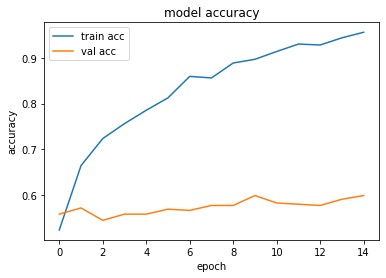

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test,Y_test)

7/7 [==============================] - 3s 358ms/step - loss: 4.9547 - accuracy: 0.6000


[4.954660892486572, 0.6000000238418579]

In [ ]:
 model.save("module")

INFO:tensorflow:Assets written to: module/assets
